In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import random

from google.colab import files

In [2]:
# Upload dataset
uploaded = files.upload()


Saving mitbih_100_signals.csv to mitbih_100_signals.csv
Saving nstdb_bw_signal.csv to nstdb_bw_signal.csv
Saving nstdb_em_signal.csv to nstdb_em_signal.csv
Saving nstdb_ma_signal.csv to nstdb_ma_signal.csv


In [ ]:
# Load dataset
noise_df = pd.read_csv('nstdb.csv')

mitbih_df = pd.read_csv('mitbih_100_signals.csv')
nstdb_em_df = noise_df.loc[noise_df['type'] == 'em']
nstdb_bw_df = noise_df.loc[noise_df['type'] == 'bw']
nstdb_ma_df = noise_df.loc[noise_df['type'] == 'ma']

In [10]:
# Eksperimen 1: MLII vs noise 1
mitbih_column = 'MLII'
nstdb_column = 'noise1'

## Preprocessing

In [11]:
# Normalisasi ke [-1, 1]
def normalize(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    range_val = max_val - min_val
    if range_val > 0:
        return 2 * (signal - min_val) / range_val - 1
    else:
        return signal

# Terapkan normalisasi ke setiap sinyal
clean_signals = normalize(mitbih_df[mitbih_column].values)
bw_noise = normalize(nstdb_bw_df[nstdb_column].values)
ma_noise = normalize(nstdb_ma_df[nstdb_column].values)
em_noise = normalize(nstdb_em_df[nstdb_column].values)

# Samakan panjang sinyal untuk membuat data latih
min_len = min(len(clean_signals), len(bw_noise), len(ma_noise), len(em_noise))
clean_signals = clean_signals[:min_len]
bw_noise = bw_noise[:min_len]
ma_noise = ma_noise[:min_len]
em_noise = em_noise[:min_len]

In [12]:
# Input model adalah sinyal bersih yang ditambah dengan noise
# Kita buat 3 set data noisy, lalu kita gabungkan
noisy_bw = clean_signals + bw_noise
noisy_ma = clean_signals + ma_noise
noisy_em = clean_signals + em_noise

# Gabungkan semua sinyal noisy menjadi satu dataset input (X)
# dan duplikasi sinyal bersih sebagai target (Y)
X_all_noisy = np.concatenate([noisy_bw, noisy_ma, noisy_em])
Y_all_clean = np.concatenate([clean_signals, clean_signals, clean_signals])

In [13]:
# Segmentasi sinyal menjadi window_size
window_size = 256

def segment_signal(signal, window_size):
    segments = []
    for i in range(0, len(signal) - window_size, window_size):
        segments.append(signal[i:i+window_size])
    # Reshape untuk input ke model Conv1D -> (jumlah_sampel, panjang_window, channel)
    return np.array(segments).reshape(-1, window_size, 1)

X_segments = segment_signal(X_all_noisy, window_size)
Y_segments = segment_signal(Y_all_clean, window_size)

# Bagi data menjadi data latih dan data validasi
X_train, X_val, Y_train, Y_val = train_test_split(
    X_segments, Y_segments, test_size=0.2, random_state=42
)

print("Bentuk data latih (X):", X_train.shape)
print("Bentuk data latih (Y):", Y_train.shape)
print("Bentuk data validasi (X):", X_val.shape)
print("Bentuk data validasi (Y):", Y_val.shape)

Bentuk data latih (X): (6093, 256, 1)
Bentuk data latih (Y): (6093, 256, 1)
Bentuk data validasi (X): (1524, 256, 1)
Bentuk data validasi (Y): (1524, 256, 1)


## Model Autoencoder

In [14]:
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # --- ENCODER (Kompresi) ---
    # Blok 1: Input -> 256x1 -> 128x32
    x = Conv1D(filters=32, kernel_size=7, padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(pool_size=2, padding="same")(x) # Downsampling

    # Blok 2: 128x32 -> 64x64
    x = Conv1D(filters=64, kernel_size=7, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    encoded = MaxPooling1D(pool_size=2, padding="same")(x) # Bottleneck

    # --- DECODER (Rekonstruksi) ---
    # Blok 3: 64x64 -> 128x32
    x = Conv1D(filters=32, kernel_size=7, padding="same")(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(size=2)(x) # Upsampling

    # Blok 4: 128x32 -> 256x1
    x = Conv1D(filters=64, kernel_size=7, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(size=2)(x)

    # Layer Output
    # Merekonstruksi sinyal kembali ke 1 channel dengan aktivasi tanh
    # karena data dinormalisasi ke rentang [-1, 1]
    decoded = Conv1D(filters=1, kernel_size=7, activation="tanh", padding="same")(x)

    model = Model(input_layer, decoded)
    optimizer = Adam(learning_rate=0.001) # Learning rate sedikit dinaikkan
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

autoencoder = build_autoencoder(input_shape=(window_size, 1))
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 256, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 128, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 64, 32)         │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 128, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 256, 1)         │           449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,641 (174.38 KB)

 Trainable params: 44,257 (172.88 KB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    X_train, Y_train,
    epochs=100, # Epoch bisa dikurangi karena konvergensi mungkin lebih cepat
    batch_size=64, # Batch size bisa diperbesar untuk stabilitas
    validation_data=(X_val, Y_val), # Menggunakan validation data yang sudah dipisah
    callbacks=[early_stopping]
)

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.1060 - val_loss: 0.0141
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040 - val_loss: 0.0100
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0073
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

## Denoising dan Evaluasi

In [17]:
# Fungsi metrik evaluasi (sesuai dari soal)
def calculate_rmse(clean, denoised):
    return np.sqrt(np.mean((clean - denoised) ** 2))

def calculate_prd(clean, denoised):
    # Hindari pembagian dengan nol jika sinyal bersih nol
    sum_clean_sq = np.sum(clean ** 2)
    if sum_clean_sq == 0:
        return 0.0
    return 100 * np.sqrt(np.sum((clean - denoised) ** 2) / sum_clean_sq)

# Siapkan data uji untuk setiap jenis noise
noisy_datasets_eval = {
    'Baseline Wander': clean_signals + bw_noise,
    'Muscle Artifact': clean_signals + ma_noise,
    'Electrode Motion': clean_signals + em_noise
}

clean_eval_segments = segment_signal(clean_signals, window_size)

for noise_type, noisy_signal in noisy_datasets_eval.items():
    # Segmentasi sinyal noisy untuk evaluasi
    noisy_eval_segments = segment_signal(noisy_signal, window_size)

    # Lakukan prediksi (denoising)
    denoised_segments = autoencoder.predict(noisy_eval_segments)

    # Hitung RMSE dan PRD per segmen, lalu rata-ratakan
    rmses = [calculate_rmse(clean_eval_segments[i], denoised_segments[i]) for i in range(len(clean_eval_segments))]
    prds = [calculate_prd(clean_eval_segments[i], denoised_segments[i]) for i in range(len(clean_eval_segments))]

    print(f"--- Hasil Evaluasi untuk: {noise_type} ---")
    print(f"Rata-rata RMSE: {np.mean(rmses):.4f}")
    print(f"Rata-rata PRD : {np.mean(prds):.2f}% \n")

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Hasil Evaluasi untuk: Baseline Wander ---
Rata-rata RMSE: 0.0324
Rata-rata PRD : 18.20% 

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Hasil Evaluasi untuk: Muscle Artifact ---
Rata-rata RMSE: 0.0360
Rata-rata PRD : 20.27% 

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- Hasil Evaluasi untuk: Electrode Motion ---
Rata-rata RMSE: 0.0396
Rata-rata PRD : 22.11% 



80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


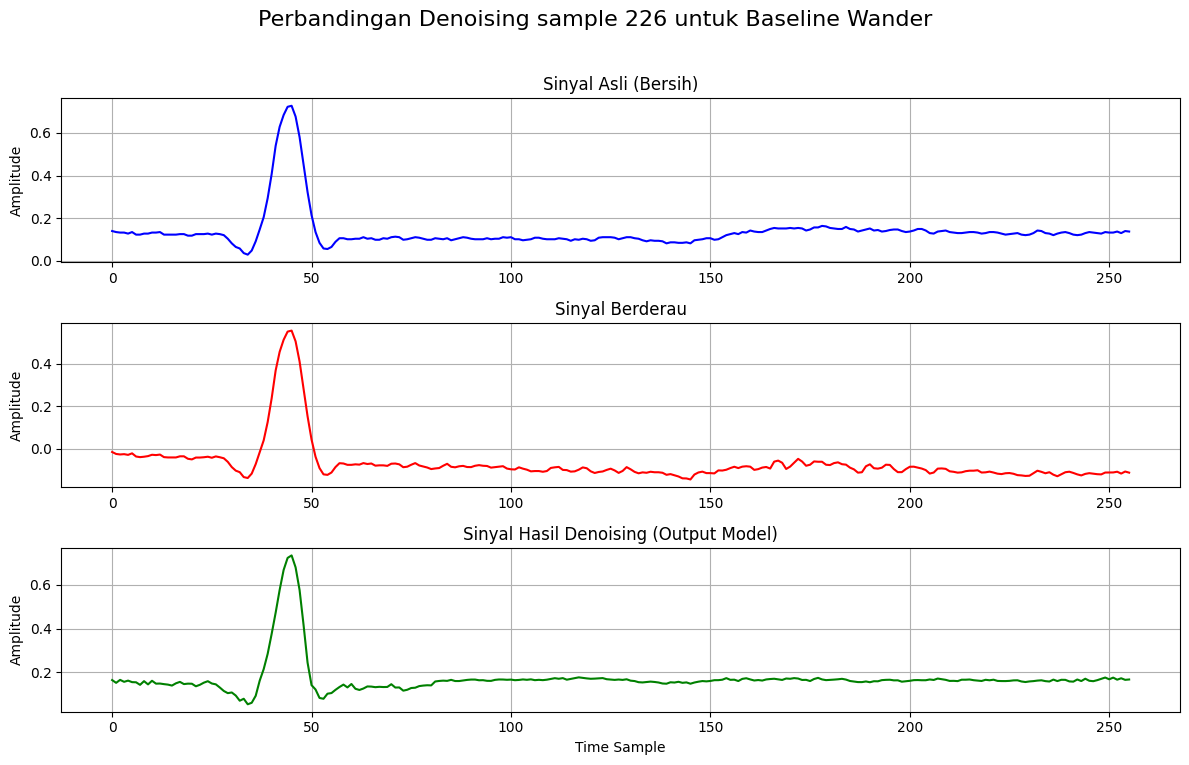

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


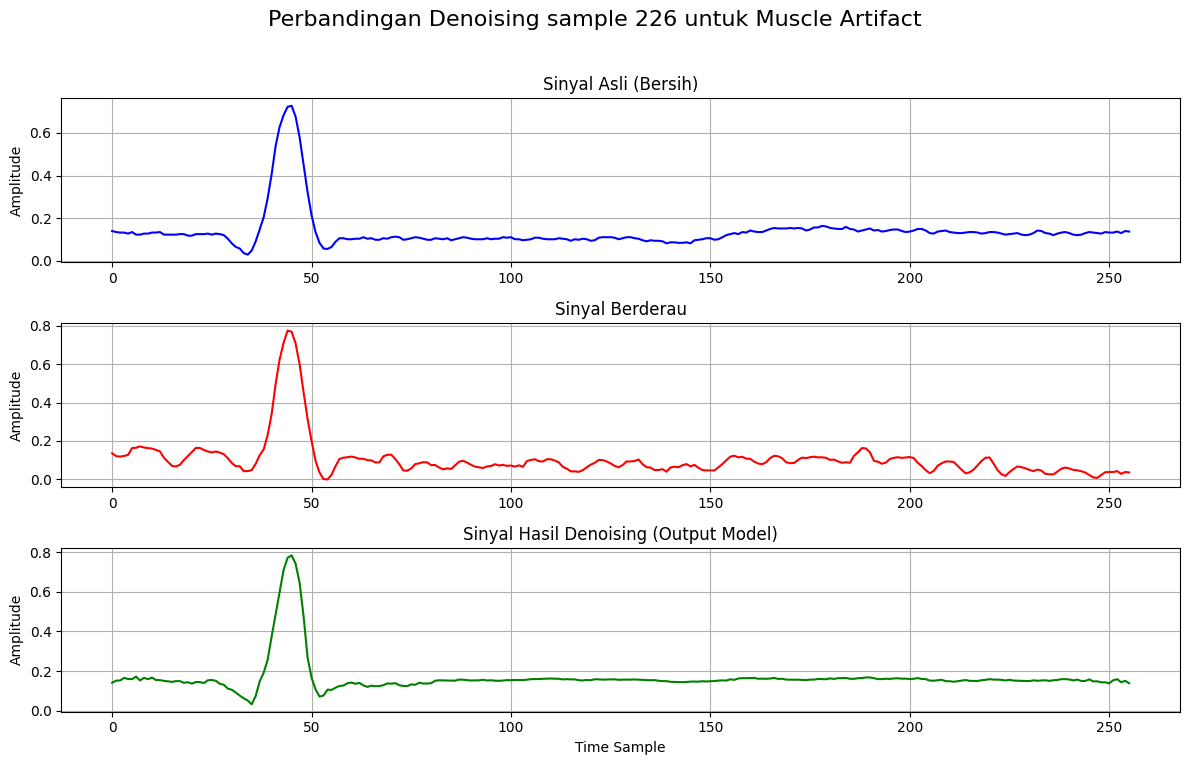

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


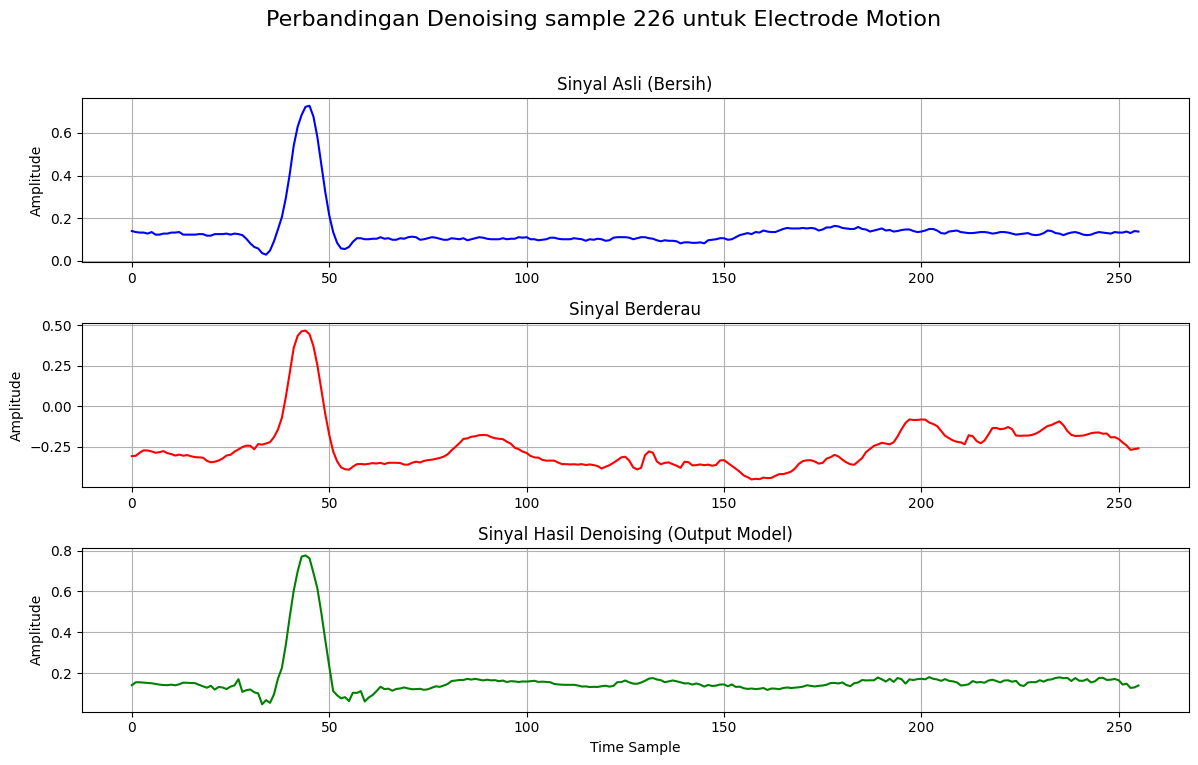

In [23]:
sample_idx = random.randint(1, 1000)

# Ulangi proses untuk setiap jenis derau
for noise_type, noisy_signal in noisy_datasets_eval.items():
    # Segmentasi sinyal bersih dan berderau
    clean_eval_segments = segment_signal(clean_signals, window_size)
    noisy_eval_segments = segment_signal(noisy_signal, window_size)

    # Lakukan prediksi (denoising)
    denoised_segments = autoencoder.predict(noisy_eval_segments)

    # Buat satu gambar perbandingan untuk jenis derau saat ini
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Perbandingan Denoising sample {sample_idx} untuk {noise_type}', fontsize=16, y=0.95)

    # 1. Plot Sinyal Asli (Bersih)
    plt.subplot(3, 1, 1)
    plt.plot(clean_eval_segments[sample_idx], 'b-', label="Sinyal Asli (Bersih)")
    plt.title("Sinyal Asli (Bersih)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # 2. Plot Sinyal Berderau
    plt.subplot(3, 1, 2)
    plt.plot(noisy_eval_segments[sample_idx], 'r-', label="Sinyal Berderau")
    plt.title("Sinyal Berderau")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # 3. Plot Sinyal Hasil Denoising
    plt.subplot(3, 1, 3)
    plt.plot(denoised_segments[sample_idx], 'g-', label="Sinyal Hasil Denoising")
    plt.title("Sinyal Hasil Denoising (Output Model)")
    plt.xlabel("Time Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
